In [5]:
# 导入 TensorFlow 和 TensorFlow Eager
import tensorflow as tf

# 导入函数来生成玩具分类问题
from sklearn.datasets import load_wine
from sklearn.datasets import make_classification
from sklearn.datasets import make_regression

# 为数据预处理导入 numpy
import numpy as np

# 导入绘图库
import matplotlib.pyplot as plt
%matplotlib inline

# 为降维导入 PCA
from sklearn.decomposition import PCA

# 开启 Eager 模式。一旦开启不能撤销！只执行一次。
tf.executing_eagerly()

True

In [6]:
wine_data = load_wine()

print('Type of data in the wine_data dictionary: ', list(wine_data.keys()))
'''
Type of data in the wine_data dictionary:  ['data', 'target', 'target_names', 'DESCR', 'feature_names']
'''

print('Number of classes: ', len(np.unique(wine_data.target)))
# Number of classes:  3

print('Distribution of our targets: ', np.unique(wine_data.target, return_counts=True)[1])
# Distribution of our targets:  [59 71 48]

print('Number of features in the dataset: ', wine_data.data.shape[1])
# Number of features in the dataset:  13

Type of data in the wine_data dictionary:  ['data', 'target', 'target_names', 'DESCR', 'feature_names']
Number of classes:  3
Distribution of our targets:  [59 71 48]
Number of features in the dataset:  13


In [7]:
# 数据集标准化
wine_data.data = (wine_data.data - np.mean(wine_data.data, axis=0))/np.std(wine_data.data, axis=0)

print('Standard deviation of each feature after standardization: ', np.std(wine_data.data, axis=0))
# Standard deviation of each feature after standardization:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Standard deviation of each feature after standardization:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


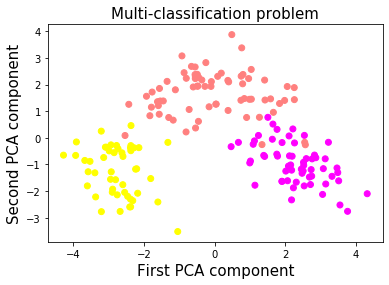

In [8]:
X_pca = PCA(n_components=2, random_state=2018).fit_transform(wine_data.data)

plt.scatter(X_pca[:,0], X_pca[:,1], c=wine_data.target, cmap=plt.cm.spring)
plt.xlabel('First PCA component', fontsize=15)
plt.ylabel('Second PCA component', fontsize=15)
plt.title('Multi-classification problem', fontsize=15)
plt.show()

In [9]:
class two_layer_nn(tf.keras.Model):
    def __init__(self, output_size=2, loss_type='cross-entropy'):
        super(two_layer_nn, self).__init__()
        """ 在这里定义正向传播期间
            使用的神经网络层     
            Args:
                output_size: int (default=2). 
                loss_type: string, 'cross-entropy' or 'regression' (default='cross-entropy')
        """   
        # 第一个隐层
        self.dense_1 = tf.layers.Dense(20, activation=tf.nn.relu)
        # 第二个隐层
        self.dense_2 = tf.layers.Dense(10, activation=tf.nn.relu)
        # 输出层，未缩放的对数概率
        self.dense_out = tf.layers.Dense(output_size, activation=None)     
        # 初始化损失类型
        self.loss_type = loss_type
    
    def predict(self, input_data):
        """ 在神经网络上执行正向传播     
            Args:
                input_data: 2D tensor of shape (n_samples, n_features).   
            Returns:
                logits: unnormalized predictions.
        """
        layer_1 = self.dense_1(input_data)
        layer_2 = self.dense_2(layer_1)
        logits = self.dense_out(layer_2)
        return logits
    
    def loss_fn(self, input_data, target):
        """ 定义训练期间使用的损失函数
        """
        preds = self.predict(input_data)
        if self.loss_type=='cross-entropy':
            loss = tf.losses.sparse_softmax_cross_entropy(labels=target, logits=preds)
        else:
            loss = tf.losses.mean_squared_error(target, preds)
        return loss
    
    def grads_fn(self, input_data, target):
        """ 在每个正向步骤中，
            动态计算损失值对模型参数的梯度
        """
        with tfe.GradientTape() as tape:
            loss = self.loss_fn(input_data, target)
        return tape.gradient(loss, self.variables)
    
    def fit(self, input_data, target, optimizer, num_epochs=500, 
            verbose=50, track_accuracy=True):
        """ 用于训练模型的函数，
            使用所选的优化器，执行所需数量的迭代
        """   
        
        if track_accuracy:
            # Initialize list to store the accuracy of the model
            self.hist_accuracy = []     
            # Initialize class to compute the accuracy metric
            accuracy = tfe.metrics.Accuracy()

        for i in range(num_epochs):
            # Take a step of gradient descent
            grads = self.grads_fn(input_data, target)
            optimizer.apply_gradients(zip(grads, self.variables))
            if track_accuracy:
                # Predict targets after taking a step of gradient descent
                logits = self.predict(X)
                preds = tf.argmax(logits, axis=1)
                # Compute the accuracy
                accuracy(preds, target)
                # Get the actual result and add it to our list
                self.hist_accuracy.append(accuracy.result())
                # Reset accuracy value (we don't want to track the running mean accuracy)
                accuracy.init_variables()

In [10]:
# 创建输入特征和标签。将数据从 numpy 转换为张量
X = tf.constant(wine_data.data)
y = tf.constant(wine_data.target)

# 定义优化器
optimizer = tf.train.GradientDescentOptimizer(5e-1)

# 初始化模型
model = two_layer_nn(output_size=3)

# 在这里选择迭代数量
num_epochs = 5

# 使用梯度下降训练模型
model.fit(X, y, optimizer, num_epochs=num_epochs)

plt.plot(range(num_epochs), model.hist_accuracy);
plt.xlabel('Epoch number', fontsize=15);
plt.ylabel('Accuracy', fontsize=15);
plt.title('Training accuracy history', fontsize=15);

AttributeError: module 'tensorflow_core._api.v2.train' has no attribute 'GradientDescentOptimizer'